## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
#import pydelfi.delfi as delfi
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_fisher_pretraining as n_counts_simulator

In [5]:
importlib.reload(delfi)

<module 'pydelfi.delfi_edit' from '/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi_edit.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [6]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [7]:
theta_fiducial = np.array([0.1197, 0.76])


## Load the module

In [8]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_fisher_pretraining' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_fisher_pretraining.py'>

In [9]:
N_countsSimulator = n_counts_simulator.Model()

In [10]:
N_countsSimulator.N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [11]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [12]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

## Load data

In [13]:
N_counts_data =  N_countsSimulator.simulation(theta_fiducial, 1)
#N_counts_data =  N_countsSimulator.N_counts
N_counts_data

array([20104, 61296, 78932, 70436, 50010,  2619,  6222,  5741,  3576,
        1761,   103,   162,    78,    43,     8])

In [14]:
n_params = len(theta_fiducial)
print(n_params)
n_data_points = len(N_counts_data)
print(n_data_points)

2
15


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [15]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up the (fake) compressor

In [16]:
def compute_derivative(theta_fiducial, param_index, delta_param, log10masses = np.linspace(14, 15.5, num = 4),
                       z_min = np.linspace(0.1, 0.9, num = 5), z_max = np.linspace(0.2, 1.0, num = 5)):
    
    log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))
    
    theta_2h = theta_fiducial
    theta_2h[param_index] = theta_2h[param_index] + 2*delta_param
    counts_2h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_2h)
    
    theta_h = theta_fiducial
    theta_h[param_index] = theta_h[param_index] + delta_param
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h)
    
    theta_h_neg = theta_fiducial
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h_neg)
    
    
    theta_2h_neg = theta_fiducial
    theta_2h_neg[param_index] = theta_2h_neg[param_index] - 2*delta_param
    counts_2h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_2h_neg)
    
    deriv = (-counts_2h + 8*counts_h - 8*counts_h_neg + counts_2h_neg)/(12*delta_param)
    
    return deriv
    

In [17]:
mu = N_countsSimulator.N_counts
Cinv = np.linalg.inv(np.diag(N_countsSimulator.N_counts))

deriv_omega_cdm = compute_derivative(theta_fiducial, 0, 0.01*theta_fiducial[0])
deriv_sigma8 = compute_derivative(theta_fiducial, 1, 0.01*theta_fiducial[1])
dmudt = np.stack((deriv_omega_cdm, deriv_sigma8))

In [18]:
Compressor = score.Gaussian(len(N_counts_data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)

In [19]:
Compressor.compute_fisher()

In [20]:
Finv = Compressor.Finv
Finv

array([[ 7.49378517e-07, -9.02737058e-07],
       [-9.02737058e-07,  1.32527761e-06]])

In [21]:
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load compressed data

In [22]:
compressed_data = compressor(N_counts_data, compressor_args)

In [23]:
compressed_data 

array([0.11866326, 0.76056077])

## Define ensemble of NDEs

In [24]:
n_params = len(theta_fiducial)
print(n_params)
n_data_points = len(compressed_data)
print(n_data_points)

2
2


In [25]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
        ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]


## Create DELFI object

In [26]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                            results_dir = "simulators/mass_function_n_counts/results_tinker_2params_fisher_6ndes_10populations/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs

Done


Sampling approximate posterior...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.
Removed no burn in


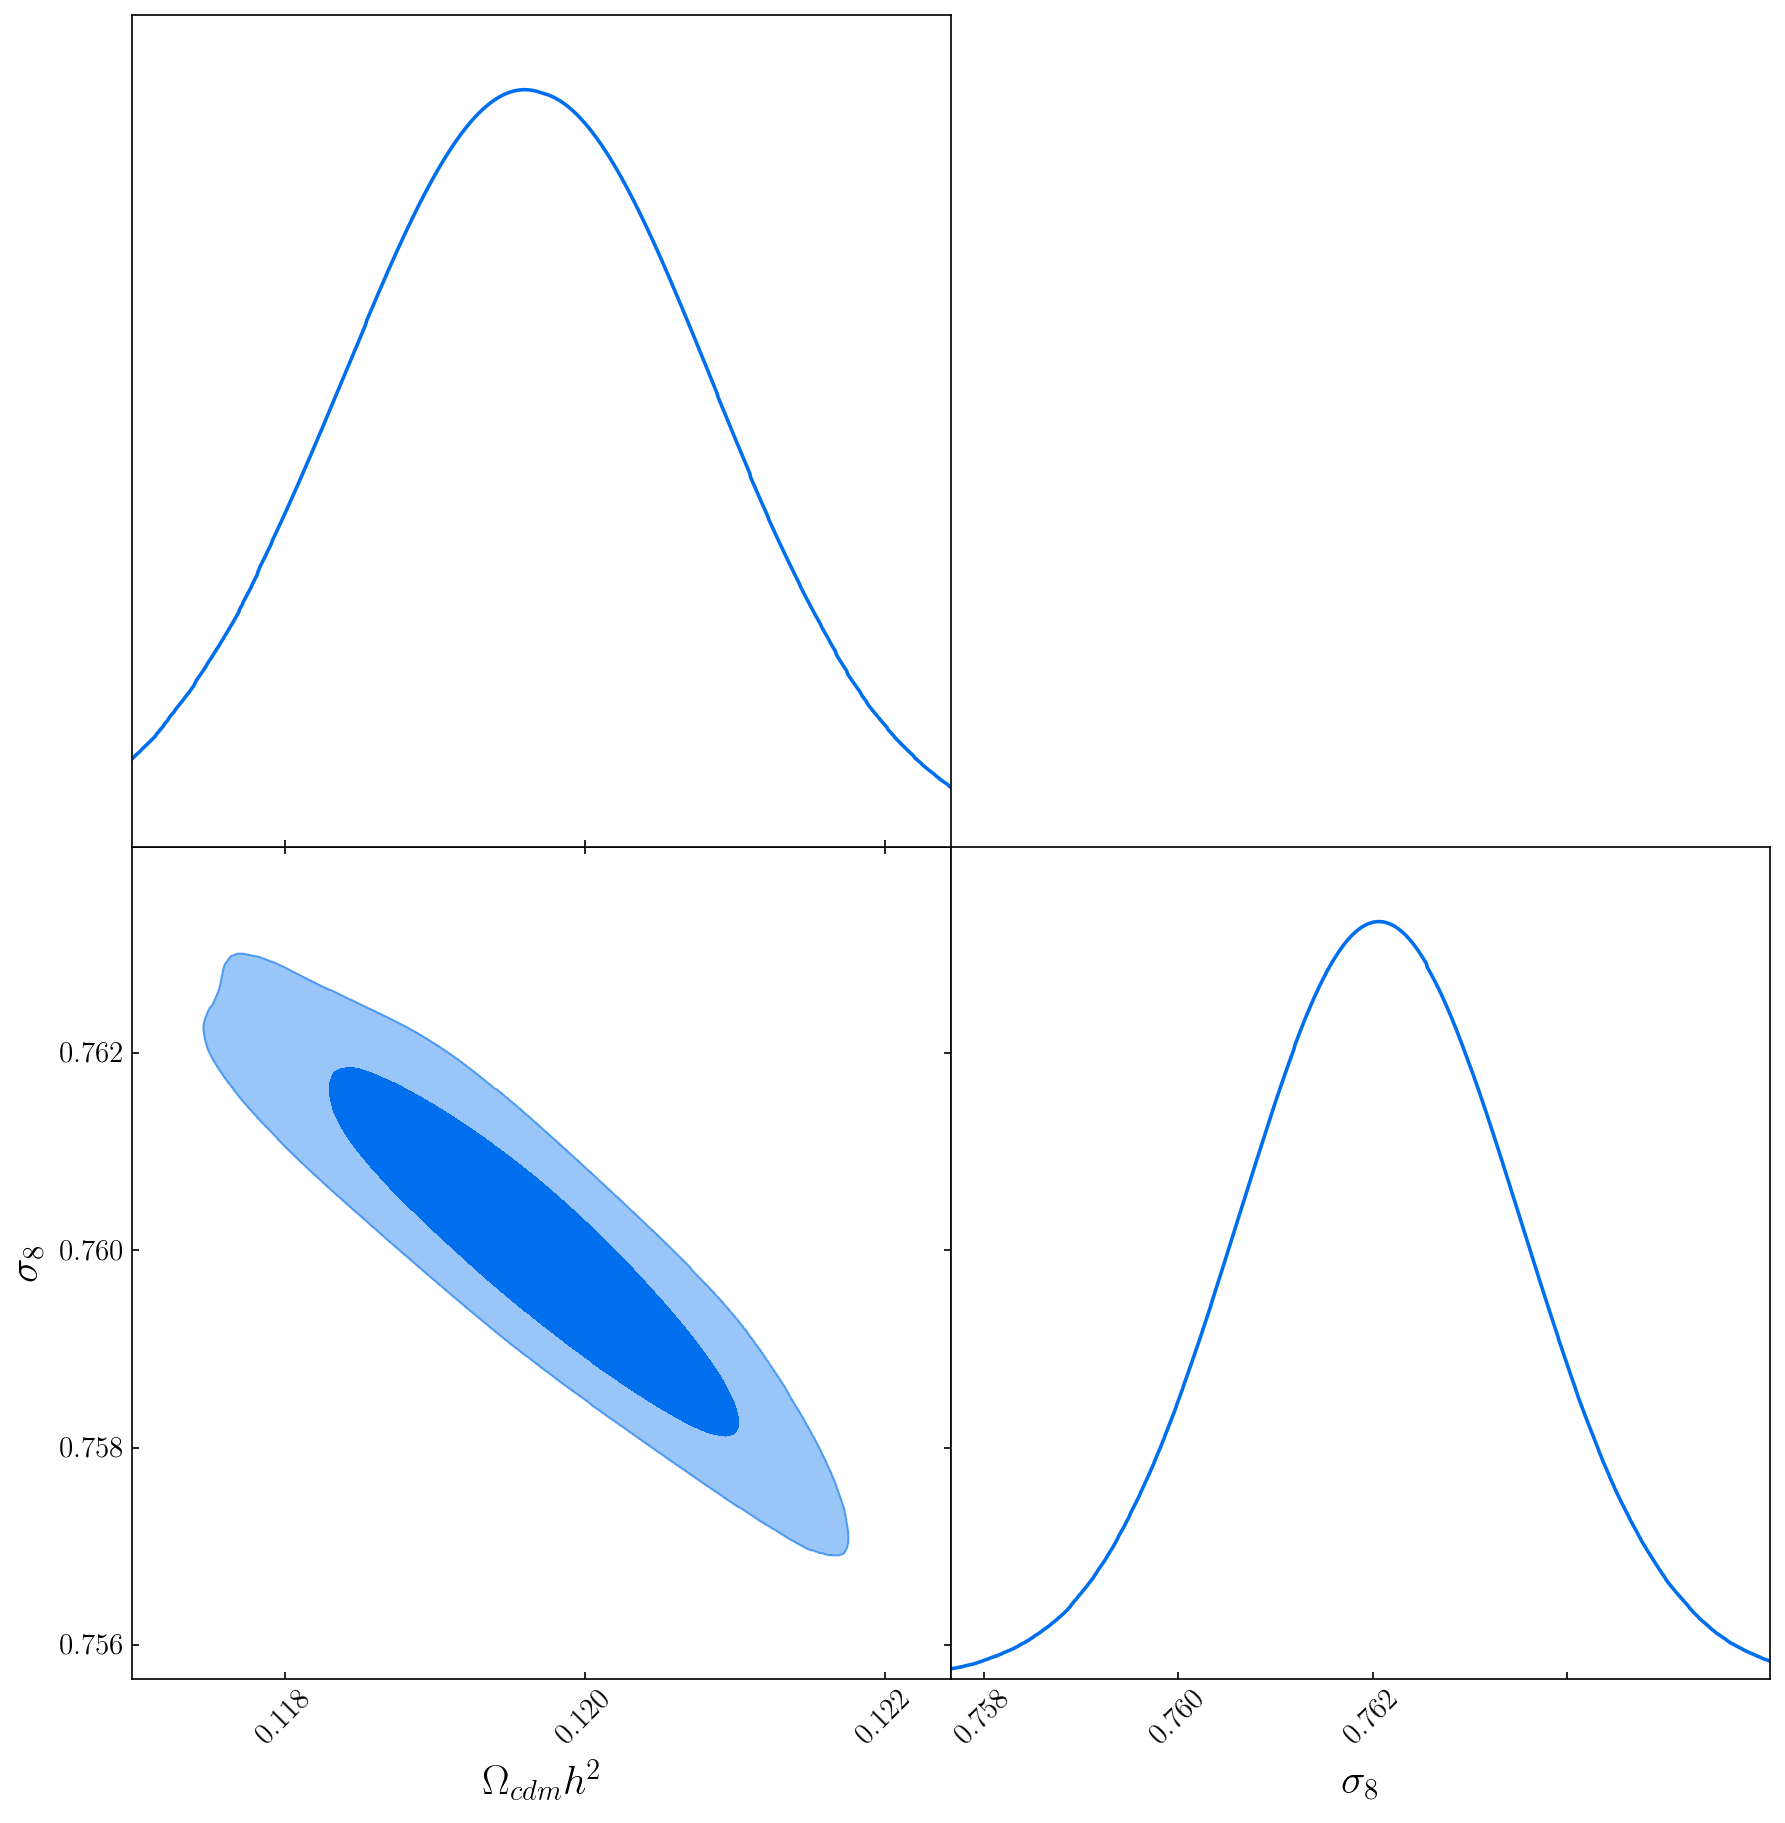

In [27]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood

Population 1/10
Sampling proposal density...
Done.


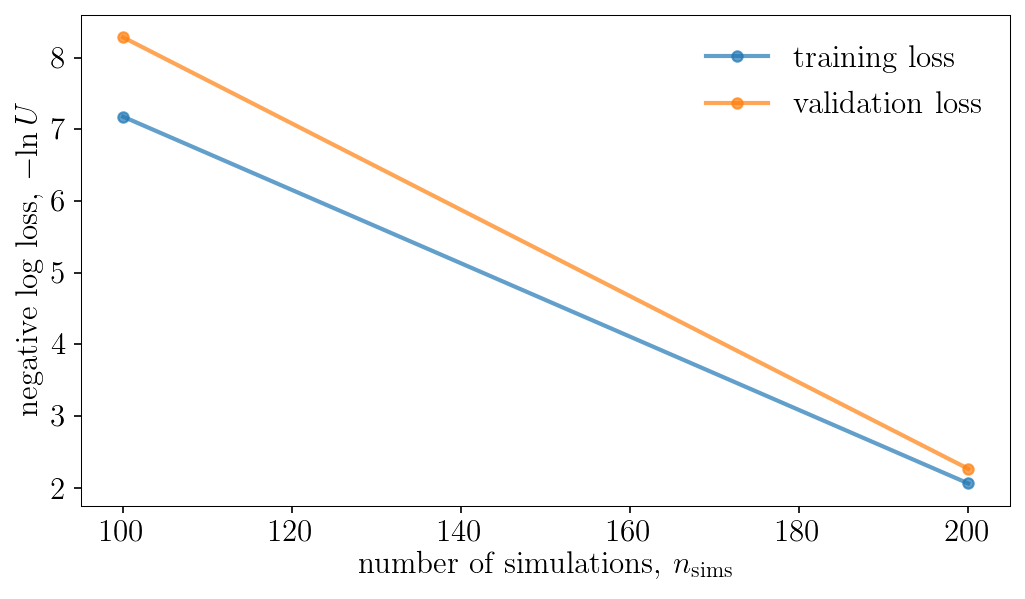

Population 2/10
Sampling proposal density...
Done.


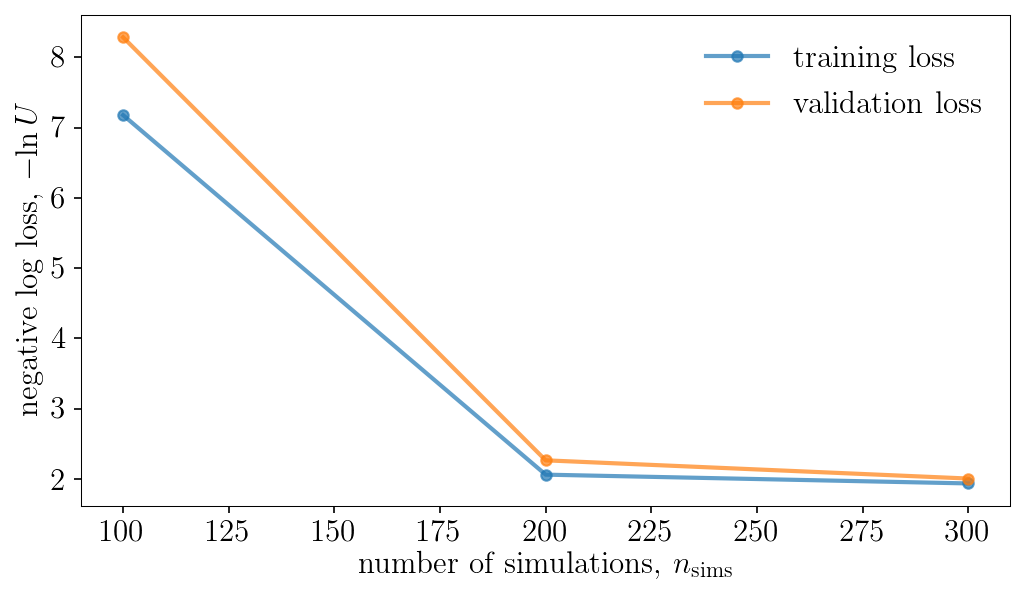

Population 3/10
Sampling proposal density...
Done.


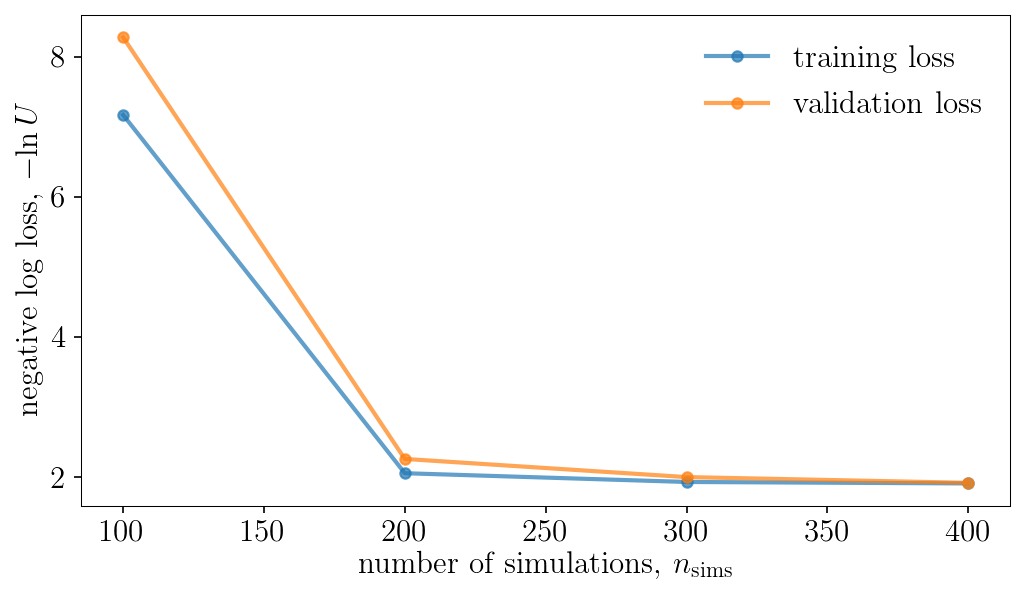

Population 4/10
Sampling proposal density...
Done.


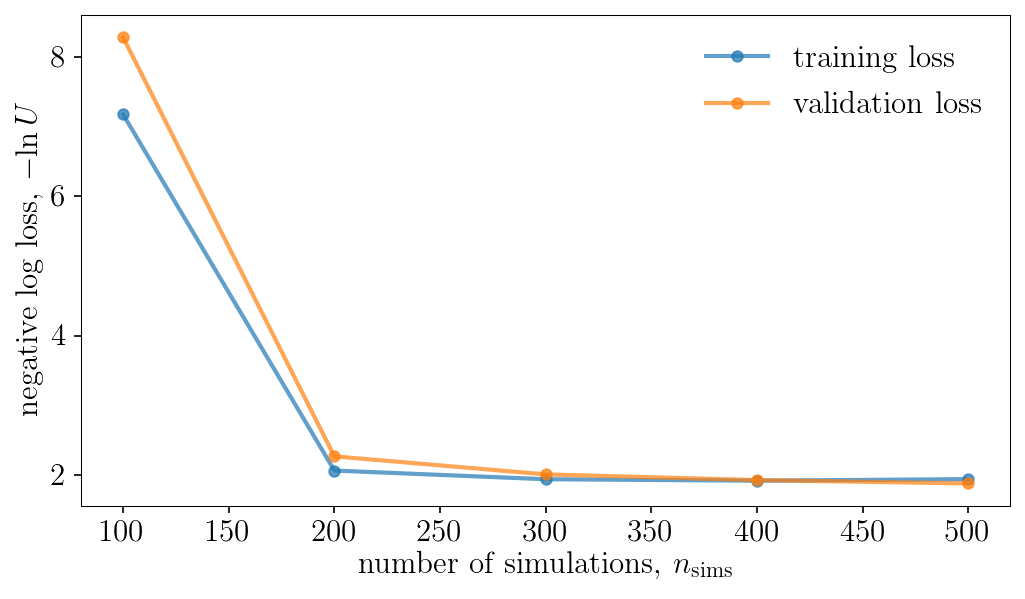

Population 5/10
Sampling proposal density...
Done.


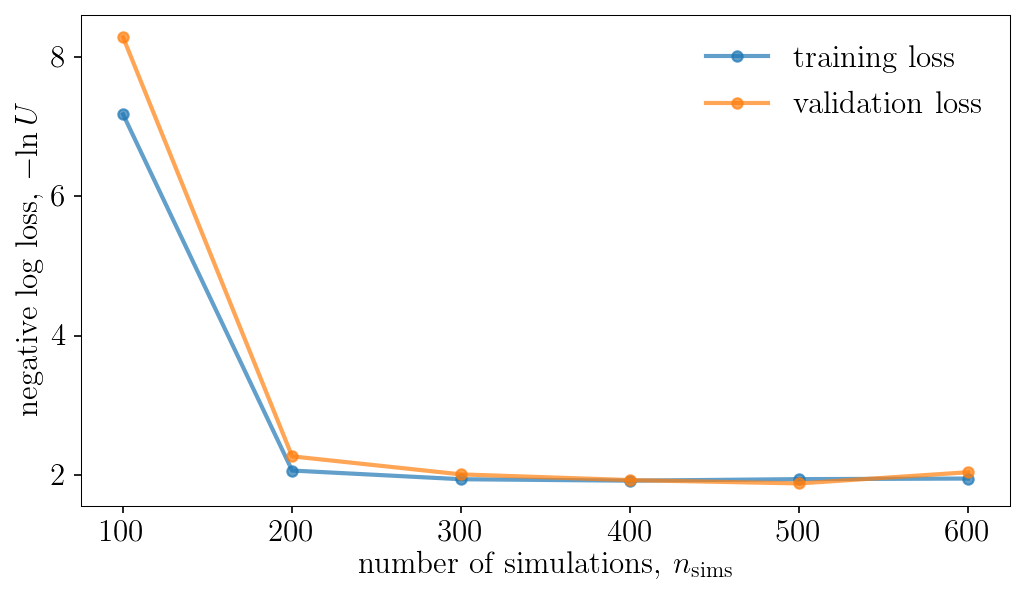

Population 6/10
Sampling proposal density...
Done.


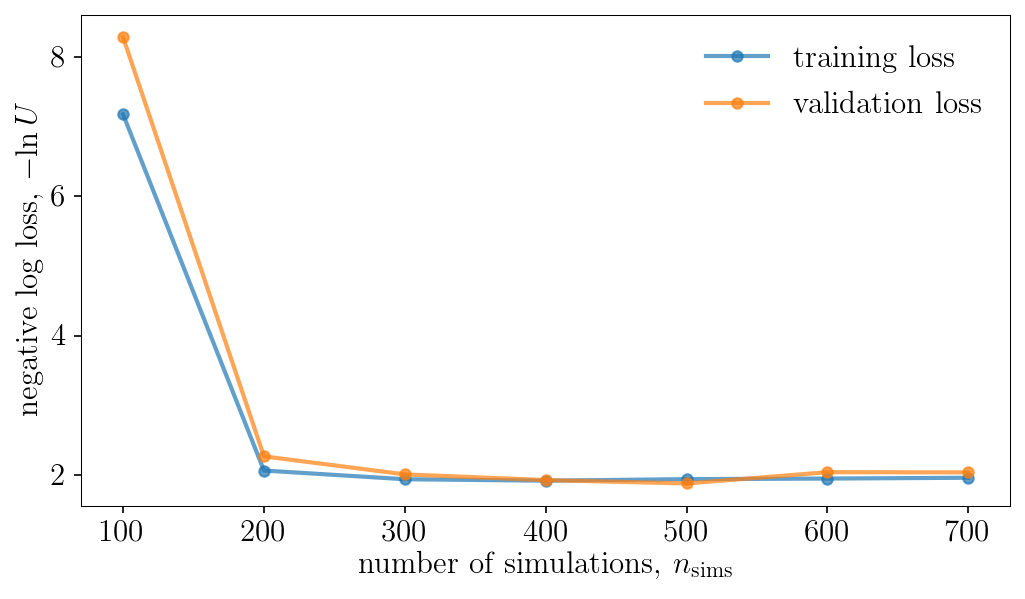

Population 7/10
Sampling proposal density...
Done.


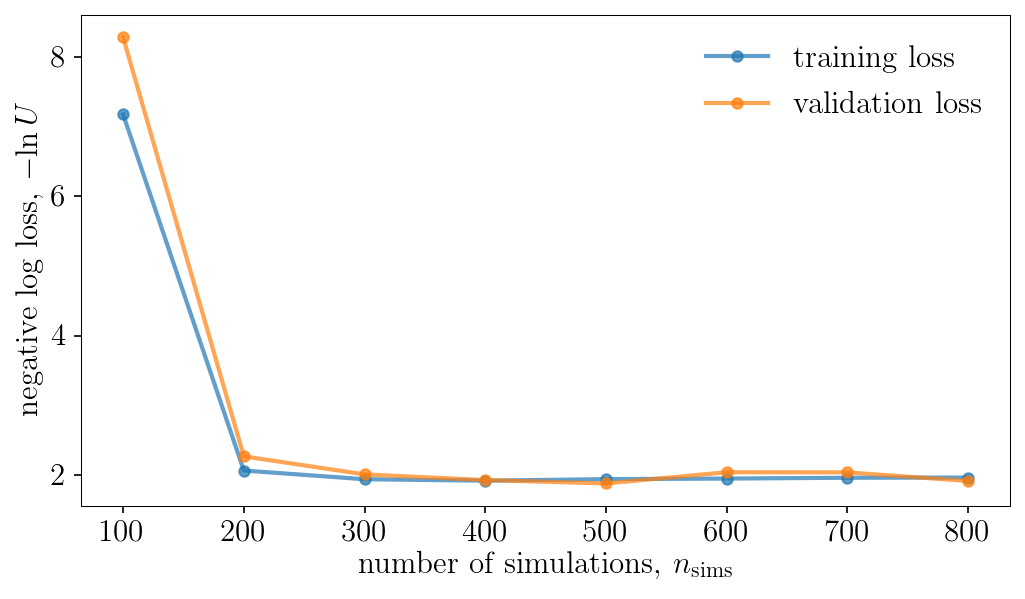

Population 8/10
Sampling proposal density...
Done.


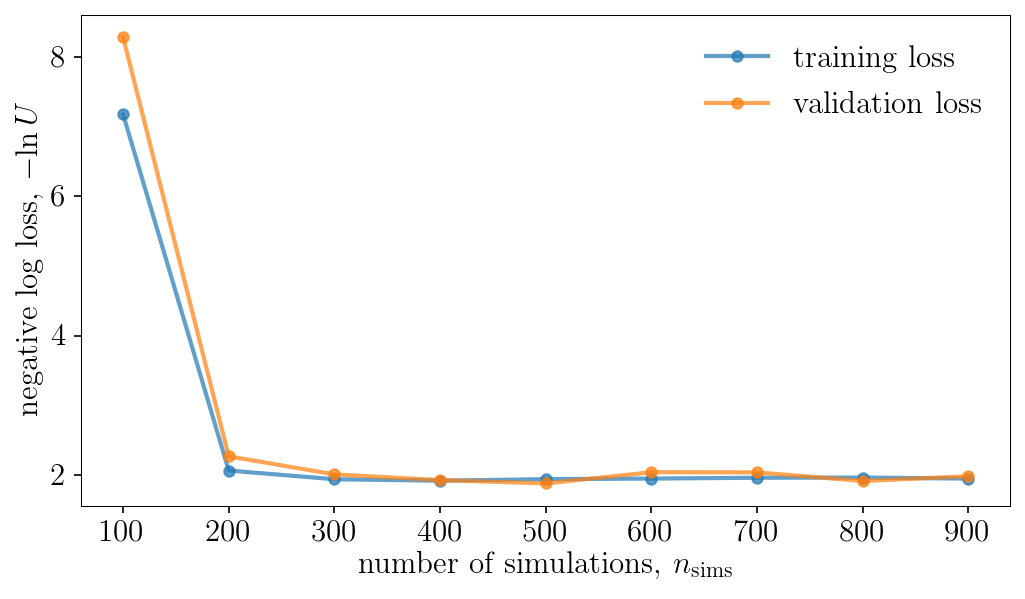

Population 9/10
Sampling proposal density...
Done.


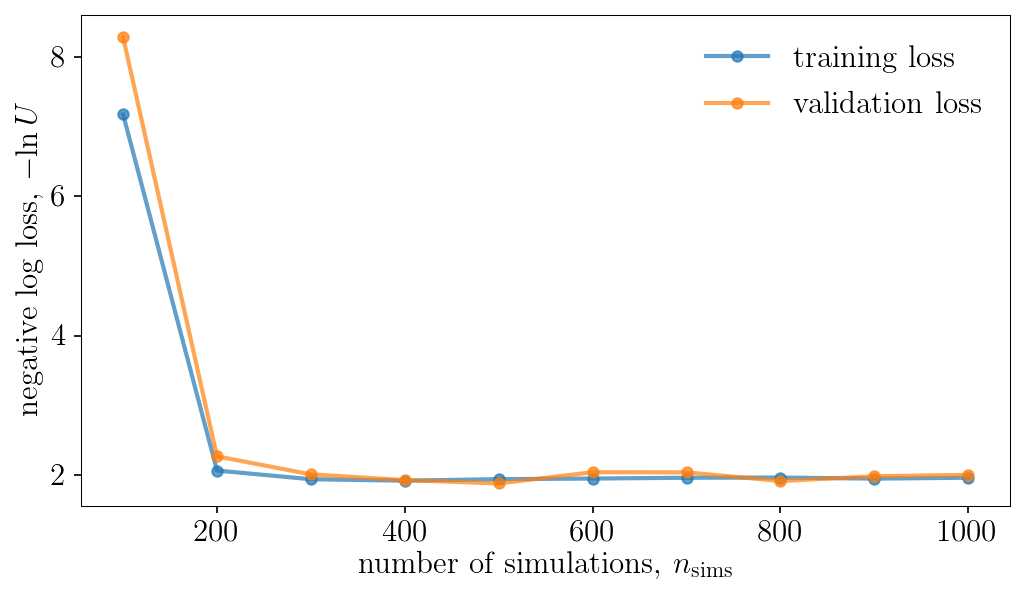

Population 10/10
Sampling proposal density...
Done.


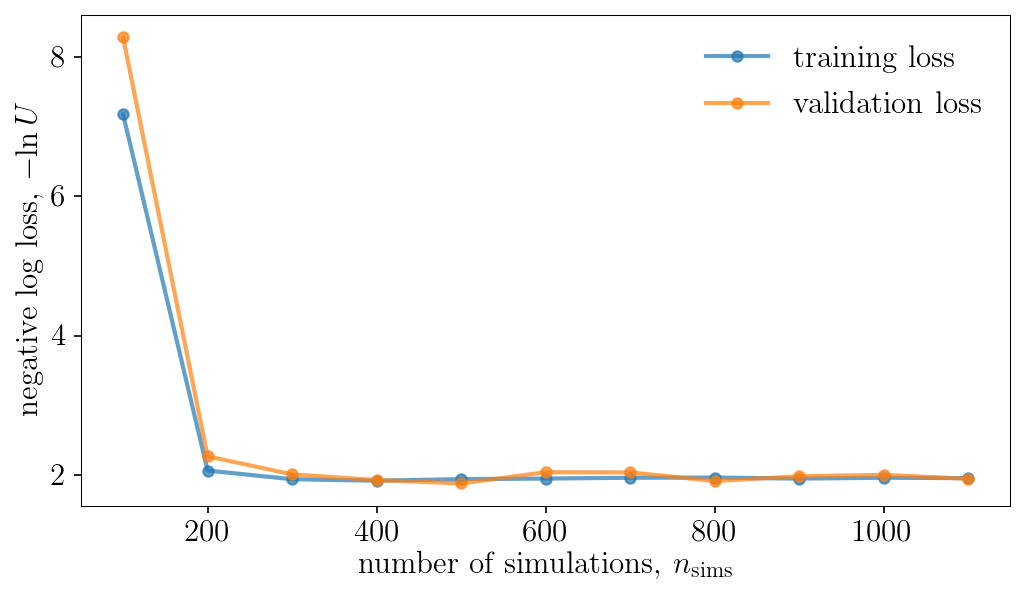

In [28]:
n_initial = 100
n_batch = 100
n_populations = 10

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

In [29]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), 
                                                       p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

Removed no burn in


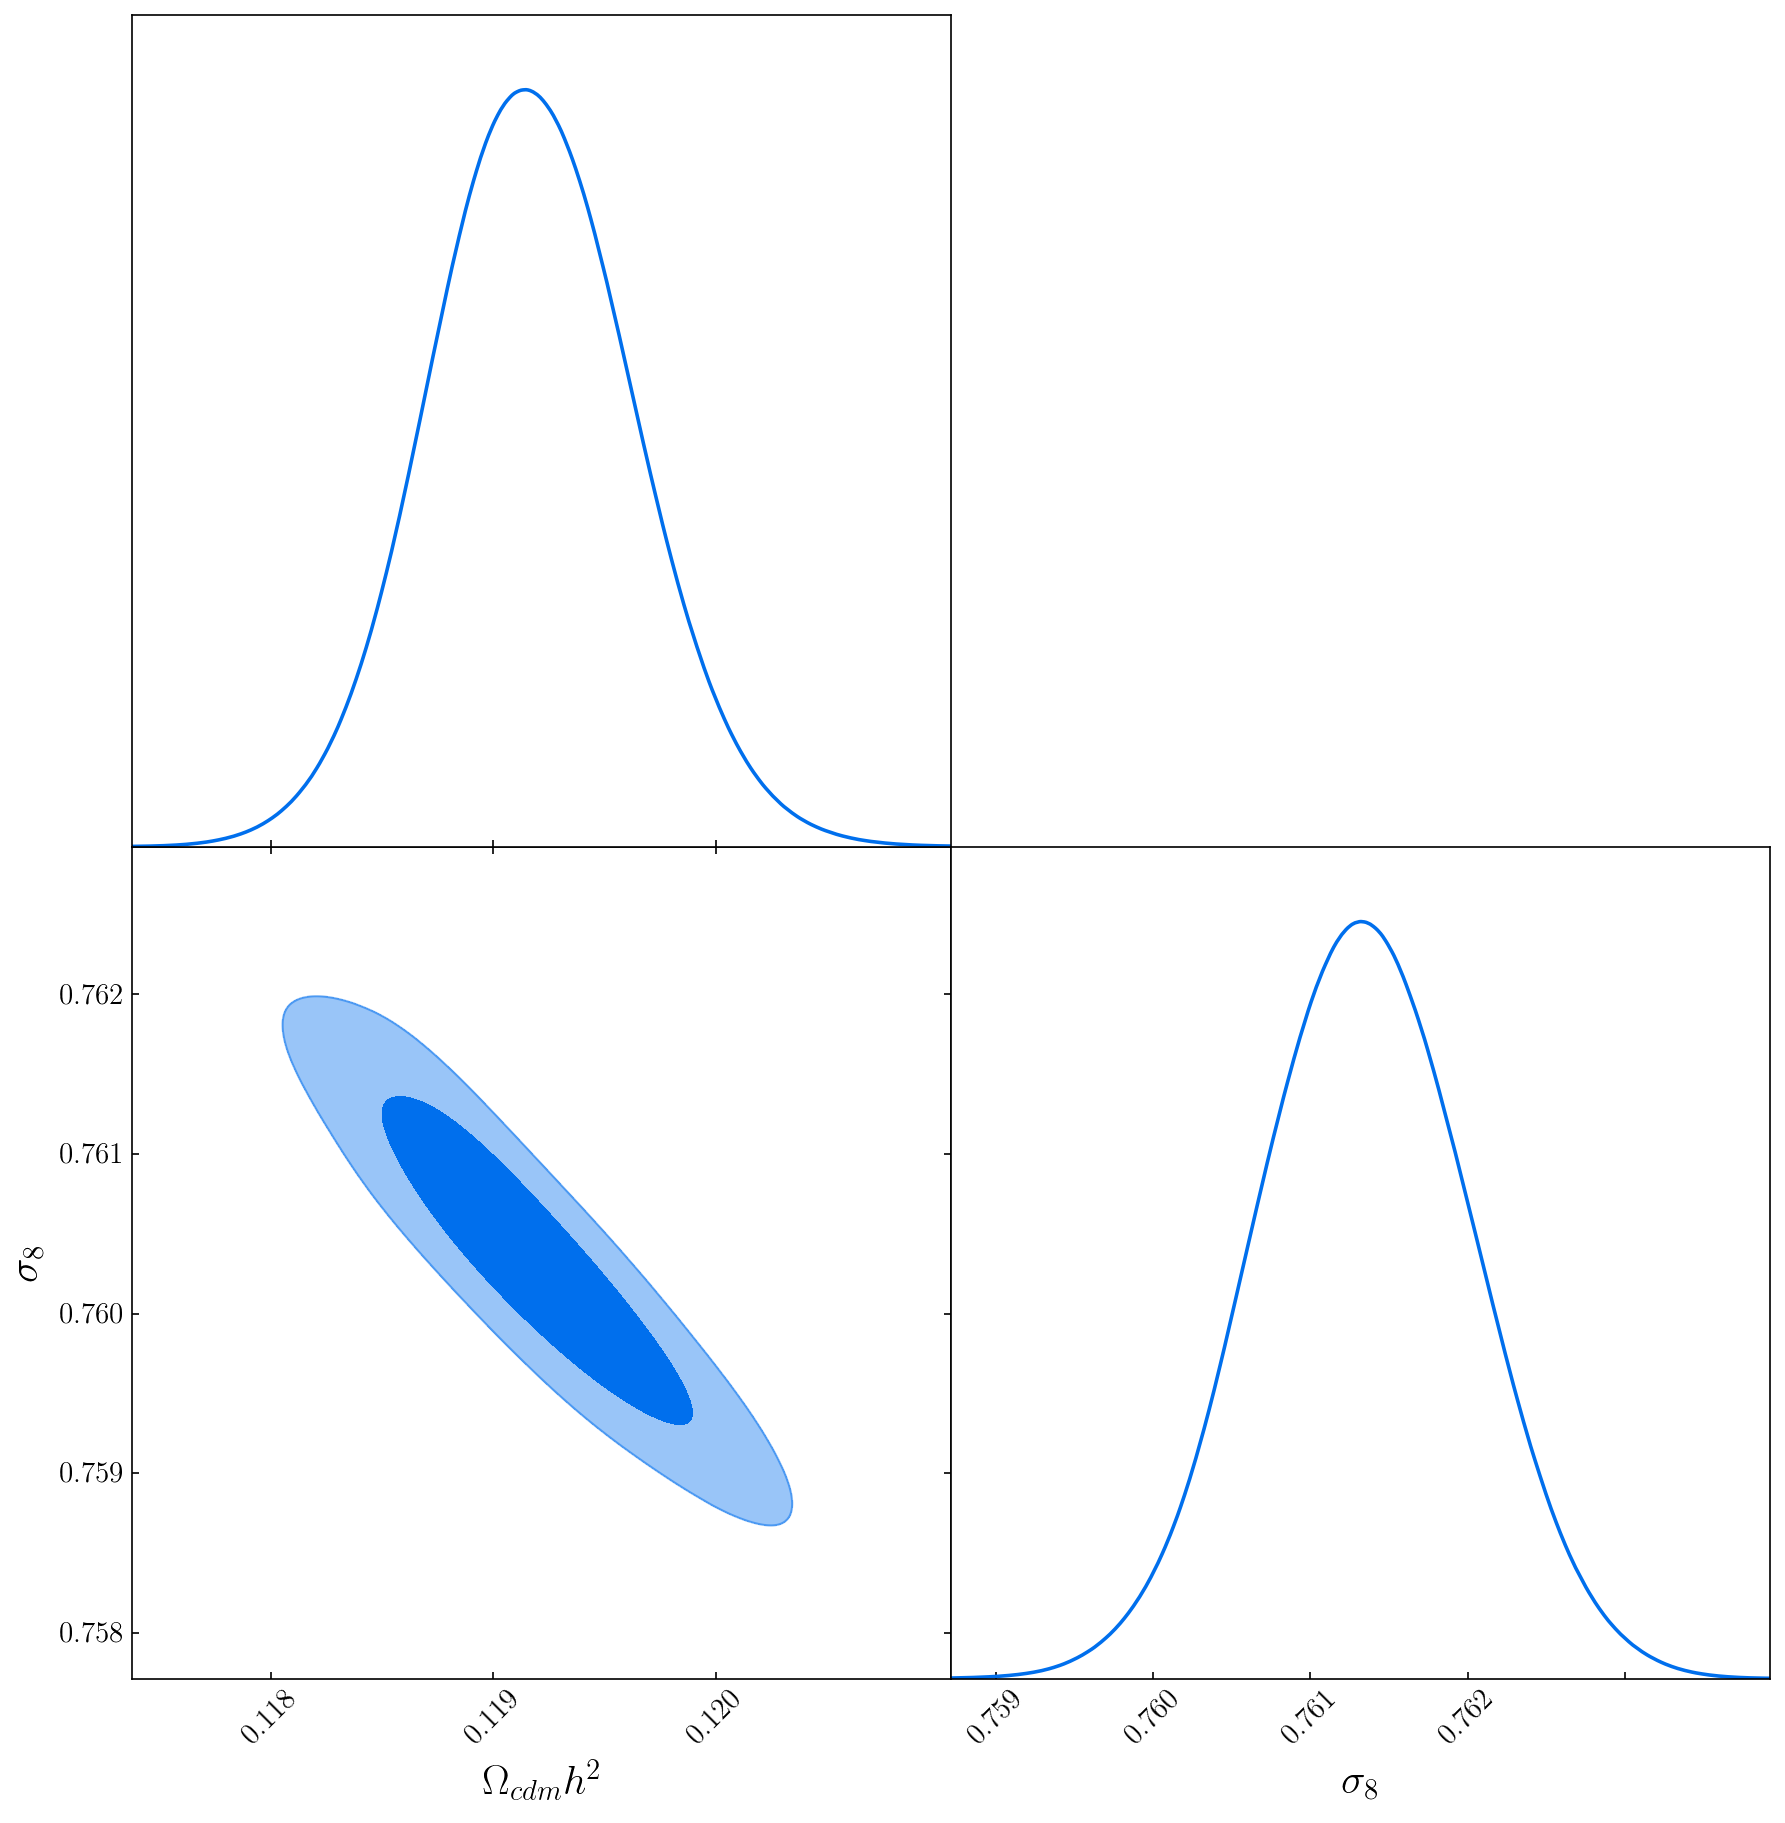

In [30]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

In [31]:
np.savetxt(DelfiEnsemble.results_dir+'posterior_samples.npy', posterior_samples)
np.savetxt(DelfiEnsemble.results_dir+'posterior_weights.npy', posterior_weights)

In [32]:
def weighted_params(posterior_samples, posterior_weights):
    results_means = np.average(posterior_samples, axis =0, weights = posterior_weights)
    
    # https://stats.stackexchange.com/questions/6534/how-do-i-calculate-a-weighted-standard-deviation-in-excel
    M_nonzero = len(np.nonzero(posterior_weights)[0])
    numerator = np.sum(((posterior_samples - results_means)**2)*posterior_weights.reshape((posterior_samples.shape[0], 1)), axis = 0)
    denominator = (M_nonzero-1)*np.sum(posterior_weights)/M_nonzero
    
    results_stdev = np.sqrt(numerator/denominator) #/np.sqrt(len(posterior_samples))
    return results_means, results_stdev

In [33]:
results_means_0, results_stdev_0 = weighted_params(posterior_samples, posterior_weights)
print('fiducial params' + str(theta_fiducial))
print(results_means_0)
print(results_stdev_0)

fiducial params[0.1197 0.76  ]
[0.11913782 0.7603493 ]
[0.00051492 0.00073554]


In [34]:
print('Upper and lower 2\sigma-limits:')
print('On \omega_cdm: [' + str((results_means_0 - 2*results_stdev_0)[0]) + ', ' + str((results_means_0 + 2*results_stdev_0)[0]), ']')
print('On \sigma_8: [' + str((results_means_0 - 2*results_stdev_0)[1]) + ', ' + str((results_means_0 + 2*results_stdev_0)[1]), ']')


Upper and lower 2\sigma-limits:
On \omega_cdm: [0.11810798894011278, 0.12016765093575067 ]
On \sigma_8: [0.7588782187466667, 0.7618203753798196 ]


In [32]:
DelfiEnsemble.results_dir

'simulators/mass_function_n_counts/results_tinker_2params_fisher_6ndes_10populations/'